In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

## Making data

In [144]:
df_h = pd.read_csv('health_data.csv')
print(df_h.head())

train_per = 0.7 #train test split
#randomize indces, take the first 80% of the indeces and last 20 percent as test
indices = np.random.permutation(df_h.shape[0])
train_ind, test_ind = indices[:int(train_per*df_h.shape[0])], indices[int(train_per*df_h.shape[0]):]
# print(len(train_ind), len(test_ind))

#select the data corresponding to the train and test indices and save into 2 dataframes. Reset index afterwards
train_df, test_df = df_h.loc[train_ind, :], df_h.loc[test_ind, :]
train_df, test_df = train_df.reset_index(drop = True), test_df.reset_index(drop = True)
# train_df.drop('index')

# Data in numpy arrays (also separating train data by classes)
X_train_0, X_train_1 = train_df.loc[train_df['category'] == 0].drop('category', axis = 1).to_numpy(),train_df.loc[train_df['category'] == 1].drop('category', axis = 1).to_numpy()
X_test, y_test = test_df.drop('category', axis = 1).to_numpy(), test_df['category'].to_numpy().reshape((-1, 1))
print(X_train_0.shape, X_train_1.shape, X_test.shape,y_train.shape, y_test.shape)

   age  restbps  chol  category
0   26      109   243         0
1   27      106   156         0
2   28      107   225         0
3   27      105   277         0
4   30       96   221         0
(286, 3) (203, 3) (211, 3) (489, 1) (211, 1)


### Some data analysis

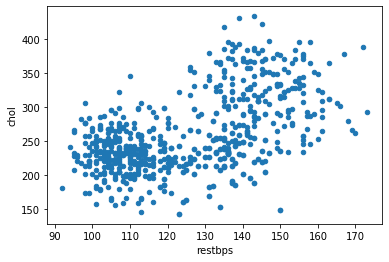

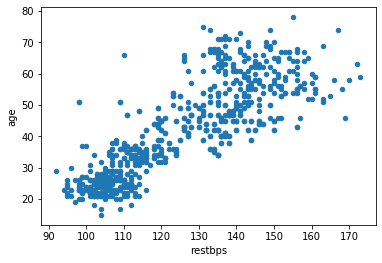

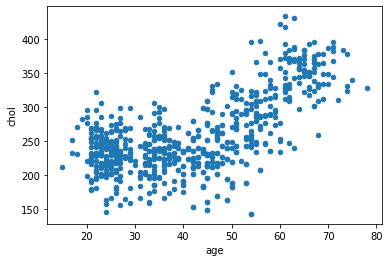

In [145]:
df_h.plot.scatter(x = 'restbps', y = 'chol')
df_h.plot.scatter(x = 'restbps', y = 'age')
df_h.plot.scatter(x = 'age', y = 'chol')

## Useful functions (EM algorithm and other functions for support)

In [264]:
def gaussian(x, mu, sigma):
    """ to get the value of pdf having params mu and sigma, @x """
#     assert(x.shape == (len(x),) and mu.shape == (len(x), ))
#     print(sigma)
    dim = len(x)
    diff = (x - mu).reshape((-1,1))
    pdf_x = (1/((np.sqrt(2*np.pi))**dim))* (1/np.sqrt(np.linalg.det(sigma))) * (np.exp(-0.5*(diff.T).dot(np.linalg.inv(sigma).dot(diff))))
#     print('dim = {}, sigmainv = {}'.format(dim, -0.5*((x-mu).T).dot(np.linalg.inv(sigma).dot(x-mu))))
    return pdf_x.item()

# def random_params(k, data):
#     pi = np.ones(k)*(1/k)
#     columns = data.shape[1]
#     mu = np.random.random((k, columns))
#     sigma = []
#     for i in range(k):
# #         sigma.append(np.eye(columns, dtype = float))
#         sigma.append(np.cov(data.T))
#     sigma = np.array(sigma)
    
#     return pi, mu, sigma
def random_params(k, data):
    """ K is the number of gaussians"""
    """if dimension is d, then mean is dX1"""
    """ init the means, covariances and mixing coefs"""
    cols = (data.shape)[1]
    #print(len(data))
    mu = np.zeros((k, cols))    #mean of k clusters KXD
    for k_ in range(k):
        idx = np.floor(rd.random()*len(data))
        for col in range(cols):
            mu[k_][col] += (data[int(idx)][col])
 
    sigma = []
    for k_ in range(k):
        sigma.append(np.cov(data.T))
 
    pi = np.ones(k)*1.0/k
    print(mu) 
    print(sigma)
    return pi, mu, sigma

def likelihood(x, pi, mu, sigma, k):
    sum = 0.
    for k_ in range(k):
        sum += pi[k_]*gaussian(x, mu[k_], sigma[k_])
    
    return sum.item()

                
def Estep(pi, mu, sigma, k, data):
    N = data.shape[0]
    mem_wts = np.zeros((N, k))
    #storing member weights in an N*k matrix
    for k_ in range(k):
        for n in range(N):
            mem_wts[n,k_] = pi[k_]*gaussian(data[n], mu[k_], sigma[k_])/(likelihood(data[n], pi, mu, sigma, k))      
                
    return mem_wts

def Mstep(mem_wts, k, data):
    N = data.shape[0]
    columns = data.shape[1]    
    mu = np.zeros((k, columns))
    sigma = np.zeros((k, columns, columns))
    pi = np.zeros(k)
    for k_ in range(k):
        mem_wts_k_ = mem_wts[:,k_].reshape(N, 1)
        Nk_ = mem_wts_k_.sum()
        pi[k_] = (Nk_)/N
        mu[k_] = (1/Nk_)*(((mem_wts_k_.T).dot(data)).sum(axis=0))
    
    for k_ in range(k):
        mem_wts_k_ = mem_wts[:,k_].reshape(N, 1)
        Nk_ = mem_wts_k_.sum()
        for n in range(N):
            diff = (data[n] - mu[k_]).reshape((-1,1))
            sigma[k_] += (mem_wts_k_[n,0])*(diff.dot(diff.T))
        sigma[k_] /= Nk_
        assert(sigma[k_].shape==(columns,columns))
                
    return pi, mu, sigma

def log_lik(pi, mu, sigma, k, data):
    log_lik = 0.
    
    for n in range(data.shape[0]):
#         print(likelihood(data[n], pi, mu, sigma, k))
        log_lik += np.log(likelihood(data[n], pi, mu, sigma, k))
    return log_lik

def EM(data, k, thresh, iter_max):
#     initialize array - pi, mu, sigmas having parameters for all the gaussians (k in number)
#     print(data[1].shape)
    pi, mu, sigma = random_params(k, data)
    log_lik_list = []
    log_lik_curr = log_lik(pi, mu, sigma, k, data)
    
    for i in range(iter_max):
        log_lik_list.append(log_lik_curr)
        
        mem_wts = Estep(pi, mu, sigma, k, data) #membership weights calculated in the E step
        pi, mu, sigma = Mstep(mem_wts, k, data) #used the membership weights to get new pi, mu, sigma
        
        #calculate new log likelihood
        log_lik_new = log_lik(pi, mu, sigma, k, data)
        
        #check if model has converged
#         if(abs(log_lik_new-log_lik_curr) < thresh):
#             break
        
        #update log likelihood
        log_lik_curr = log_lik_new
    
    print("EM converged / ended after {} iterations".format(iter_max))
    plt.plot(log_lik_list)
    plt.ylabel('Log_Likelihood')
    plt.xlabel('Iterations')
    plt.show()
    print(log_lik_curr)
    return log_lik_curr

## Modelling Class conditional densities as Sum of " num_gauss" gaussians

In [265]:
# for classifying test data we first model all the classes of the train data
# let us have data corresponding to 2 classes - data1 and data2
num_gauss = 4 #number of gaussians to model the data
thresh = 0.0001
# Class_0_params = EM(X_train_0, num_gauss, threshold)
# Class_1_params = EM(X_train_1, num_gauss, threshold)

[[ 28. 105. 266.]
 [ 24. 105. 164.]
 [ 39. 119. 247.]
 [ 21. 104. 268.]]
[array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]]), array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]]), array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]]), array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]])]
EM converged / ended after 10 iterations


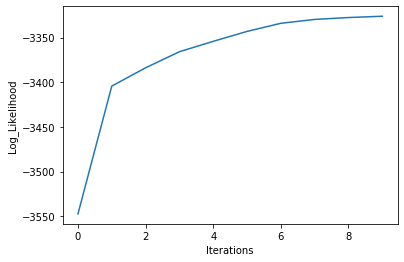

-3324.9832143532344
-3324.9832143532344


In [266]:
loglik = EM(X_train_0, num_gauss, thresh, 10)
print(loglik)

## Using the Class Conditional Parameters found above to get the Posterior

(3, 3)


In [262]:
def random_parameters(data, K):
    """ K is the number of gaussians"""
    """if dimension is d, then mean is dX1"""
    """ init the means, covariances and mixing coefs"""
    cols = (data.shape)[1]
    #print(len(data))
    mu = np.zeros((K, cols))    #mean of k clusters KXD
    for k in range(K):
        idx = np.floor(rd.random()*len(data))
        for col in range(cols):
            mu[k][col] += (data[int(idx)][col])
 
    sigma = []
    for k in range(K):
        sigma.append(np.cov(data.T))
 
    pi = np.ones(K)*1.0/K
    print(mu) 
    print(sigma)
    return mu, sigma, pi


def e_step(data, K, mu, sigma, pi):
    idvs = (data.shape)[0]
    #cols = (data.shape)[1]
    #print("idvs is " +str(idvs))
    resp = np.zeros((idvs, K))
 
    for i in range(idvs):
        for k in range(K):
            resp[i][k] = pi[k]*gaussian(data[i], mu[k], sigma[k])/likelihood(data[i], K, mu, sigma, pi)
    
    #print("responsibitlies is ")
    #print(resp) 
       
    return resp

def log_likelihood(data, K, mu, sigma, pi):
    """ marginal over X """
    log_likelihood = 0.0
    for n in range (len(data)):
        log_likelihood += np.log(likelihood(data[n], K, mu, sigma, pi))
    return log_likelihood 

 
def likelihood(x, K, mu, sigma, pi):
    rs = 0.0
    for k in range(K):
        rs += pi[k]*gaussian(x, mu[k], sigma[k])
    return rs


def m_step(data, K, resp):
    """ find the parameters that maximize the log-likelihood given the current resp."""
    idvs = (data.shape)[0]
    cols = (data.shape)[1]
    
    mu = np.zeros((K, cols))
    sigma = np.zeros((K, cols, cols))
    pi = np.zeros(K)

    marg_resp = np.zeros(K)
    for k in range(K):
        for i in range(idvs):
            marg_resp[k] += resp[i][k]
            mu[k] += (resp[i][k])*data[i]
        mu[k] /= marg_resp[k]

        for i in range(idvs):
            #x_i = (np.zeros((1,cols))+data[k])
            x_mu = np.zeros((1,cols))+data[i]-mu[k]
            sigma[k] += (resp[i][k]/marg_resp[k])*x_mu*x_mu.T

        pi[k] = marg_resp[k]/idvs        
    
    
    return mu, sigma, pi


def gaussian(x, mu, sigma):
    """ compute the pdf of the multi-var gaussian """
    idvs = len(x)
    norm_factor = (2*np.pi)**idvs

    norm_factor *= np.linalg.det(sigma)
    norm_factor = 1.0/np.sqrt(norm_factor)

    x_mu = np.matrix(x-mu)

    rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)
    return rs

def EM(data, rst, K, threshold):
    converged = False
    mu, sigma, pi = random_parameters(data, K)
    likelihood_list=[]
    current_log_likelihood = log_likelihood(data, K, mu, sigma, pi)
    max_iter = 100
    for it in range(max_iter):
        likelihood_list.append(float(current_log_likelihood[0][0]))
        print(rst, "       |       ", it, "     |     ", current_log_likelihood[0][0])
        #print("Mixing proportion is ", pi )
        resp = e_step(data, K, mu, sigma, pi)
        mu, sigma, pi = m_step(data, K, resp)

        new_log_likelihood = log_likelihood(data, K, mu, sigma, pi)
        if (abs(new_log_likelihood-current_log_likelihood) < threshold):
            converged = True
            break

        current_log_likelihood = new_log_likelihood
    print(converged) 
    plt.plot(likelihood_list)
    plt.ylabel('log likelihood')
    plt.show()
           
    return current_log_likelihood, mu, sigma, pi, resp


[[ 42. 150. 235.]
 [ 49. 140. 248.]
 [ 23. 102. 234.]
 [ 21.  95. 233.]]
[array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]]), array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]]), array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]]), array([[  86.74779782,   93.72394798,  -15.0409643 ],
       [  93.72394798,  158.24273095,  -28.71165501],
       [ -15.0409643 ,  -28.71165501, 1032.83922218]])]
1        |        0      |      [[-3604.89521517]]
1        |        1      |      [[-3371.59974322]]
1        |        2      |      [[-3361.5123845]]
1        |        3      |      [[-3356.11763691]]
1        |        4      |      [[-3353.07664911]]
1        |      

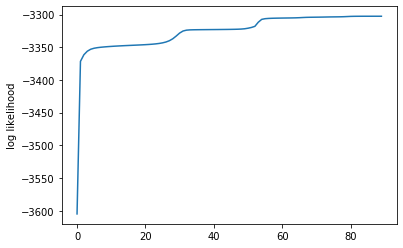

(matrix([[-3302.63575059]]),
 array([[ 37.73979645, 137.63070826, 215.80656878],
        [ 44.68627458, 129.47992833, 230.10104984],
        [ 24.14300974, 104.79691871, 232.30119524],
        [ 34.39045535, 114.14153229, 231.50343167]]),
 array([[[ 1.51649831e+01,  1.98044411e+01, -1.42998967e+02],
         [ 1.98044411e+01,  3.17855589e+01, -1.87957573e+02],
         [-1.42998967e+02, -1.87957573e+02,  1.42639209e+03]],
 
        [[ 2.31224317e+01,  6.75162358e+00,  1.70596496e+01],
         [ 6.75162358e+00,  9.17731988e+01,  1.62582177e+01],
         [ 1.70596496e+01,  1.62582177e+01,  9.36885012e+02]],
 
        [[ 8.08583616e+00,  1.59765240e+00, -1.62172489e+01],
         [ 1.59765240e+00,  2.14140978e+01, -1.48405402e+01],
         [-1.62172489e+01, -1.48405402e+01,  9.98764296e+02]],
 
        [[ 4.29757910e+00, -1.10249105e+00,  4.56439414e+00],
         [-1.10249105e+00,  2.19979415e+01, -2.04485298e+01],
         [ 4.56439414e+00, -2.04485298e+01,  1.14156963e+03]]]),
 arra

In [263]:
EM(X_train_0, 1, num_gauss, thresh)